# Tutorial 1. The Realm of Supervised Learning

In this notebook we will cover the following:

1. [Preprocesing data using different techniques](#preprocess)
2. [Label encoding](#labelencoding)
3. [Building a linear regressor](#linregress)
4. [Computing regression accuracy](#regacc)
5. [Acheiving model persistence](#modpers)
6. [Building a ridge regressor](#ridge)
7. [Building a polynomial regressor](#poly)
8. [Estimate house pricing](#house)
9. [Compute relative importance of features](#featimport)
10. [Estimating bicycle demand distribution](#bicycle)

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
import seaborn as sns
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

## 1.1 Preprocessing data using different techniques <a class="anchor" id="preprocess"></a>

In [2]:
from sklearn import preprocessing

data = pd.DataFrame(np.array([[3,-1.5,2,-5.4],[0,4,-0.3,2.1],[1,3.3,-1.9,-4.3]]))
data.head()

,0,1,2,3
0,3.0,-1.5,2.0,-5.4
1,0.0,4.0,-0.3,2.1
2,1.0,3.3,-1.9,-4.3


### Mean Removal
Helps to remove any bias in the features

In [3]:
data_standardized = preprocessing.scale(data)
print( "\nMean=",data_standardized.mean(axis=0))
print("\nStd deviation=",data_standardized.std(axis=0))


Mean= [  5.55111512e-17  -1.11022302e-16  -7.40148683e-17  -7.40148683e-17]

Std deviation= [ 1.  1.  1.  1.]


### Scaling
Sometimes the values of each feature in a datapoint can vary between random values. Scaling makes it level playing field.

In [4]:
data_scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
data_scaled = data_scaler.fit_transform(data)
print('\nMin max scaled data =\n',data_scaled)


Min max scaled data =
 [[ 1.          0.          1.          0.        ]
 [ 0.          1.          0.41025641  1.        ]
 [ 0.33333333  0.87272727  0.          0.14666667]]


### Normalization

Adjust the values in feature vector so they can be measured on a common scale. One of the most common forms is to normalize so they sum up to 1 (along a row)

In [5]:
data_normalized = preprocessing.normalize(data,norm='l1')
print('\nL1 Normalized data =\n',data_normalized)


L1 Normalized data =
 [[ 0.25210084 -0.12605042  0.16806723 -0.45378151]
 [ 0.          0.625      -0.046875    0.328125  ]
 [ 0.0952381   0.31428571 -0.18095238 -0.40952381]]


### Binarization
Want to convert numerical feature vector into a Boolean vector

In [6]:
data_binarized = preprocessing.Binarizer(threshold=1.4).transform(data)
print('\nBinarized data =\n',data_binarized)


Binarized data =
 [[ 1.  0.  1.  0.]
 [ 0.  1.  0.  1.]
 [ 0.  1.  0.  0.]]


### One Hot Encoding
If we have sparse data, this is tool to *tighten* the feature vector. Looks at each feature and identifies the total number of distinct values. Uses a one-of-k scheme to encode the values. E.g. say we have 4D feature vector, the encoder will go through the n-th feature in each feature fector and count the # of idstinct values If the number of distinct values is k, it wil transform the feature into a k-dimensional vector where only one value is 1 and all other values are 0.

In [7]:
data = pd.DataFrame([[0,2,1,12],[1,3,5,3],[2,3,2,12],[1,2,4,3]])
display(data.head())
vector=[[2,3,5,3]]
print('vector=\n',vector)

,0,1,2,3
0,0,2,1,12
1,1,3,5,3
2,2,3,2,12
3,1,2,4,3


vector=
 [[2, 3, 5, 3]]


In [8]:
encoder = preprocessing.OneHotEncoder().fit(data)
encoded_vector= encoder.transform(vector).toarray()
print("\nEncoded vector = ",encoded_vector)


Encoded vector =  [[ 0.  0.  1.  0.  1.  0.  0.  0.  1.  1.  0.]]


In the above there are 3 distinct values in feature 0: 0,1,2 and our vector has value 2 so it's encoding is 0,0,1
in feature 1: 2,3 and our vector has value 3 so it's 0,1, feature 2 is 1,2,4,5, so value 5 is 0,0,0,1

## 1.2 Label encoding <a class="anchor" id="labelencoding"></a>
Refers to ransforming the word labels into numerical form so that the alogorthms can understand how to operate on them.

In [9]:
from sklearn import preprocessing

label_encoder= preprocessing.LabelEncoder()
input_classes= ['audi','ford','audi','toyota','ford','bmw']
label_encoder.fit(input_classes)
print('\nClass mapping:')
for i,item in enumerate(label_encoder.classes_):
    print(item,'---->',i)


Class mapping:
audi ----> 0
bmw ----> 1
ford ----> 2
toyota ----> 3


In [10]:
labels=['toyota','ford','audi']
encoded_labels = label_encoder.transform(labels)
print('\nLabels=',labels)
print("\nEncoded labels = ",list(encoded_labels))


Labels= ['toyota', 'ford', 'audi']

Encoded labels =  [3, 2, 0]


Easier than maintaing a map of dictionaries, can check correctness by transforming numbers back to word labels

In [11]:
encoded_labels=[2,1,0,3,1]
decoded_labels=label_encoder.inverse_transform(encoded_labels)
print("\nEncoded labels = ",list(encoded_labels))
print('\nDecoded labels=',decoded_labels)



Encoded labels =  [2, 1, 0, 3, 1]

Decoded labels= ['ford' 'bmw' 'audi' 'toyota' 'bmw']


## 1.3 Building a linear regressor<a class="anchor" id="linregress"></a>
Regression is proces of estimating relationship between input data and coninuous-valued output data. This data is usually in the form of real numbers, our goal is to estimate the underlying function that overns the mapping from input to output

Linear regression extracts underlying linear model, aims to minimize the sum of squares of differences between actual ouput and predicted ouput --> **Ordinary least squares**

In [12]:
data = pd.read_csv('data_singlevar.txt',names=['x','y'])
data.head()

,x,y
0,4.94,4.37
1,-1.58,1.70
2,-4.45,1.88
3,-6.06,0.56
4,-1.22,2.23


To validate machine learning model weneed to check whether it is performing satisfactory, need to separate our data into 2 groups: 
    - training group to build model
    - test group to see how accurate model is
    

In [13]:
count = len(data['x'].index)
num_training = int(0.8*count)
num_test     = count - num_training

#Train
train = data.ix[:num_training]
Xtrain= train[['x']]
ytrain= train[['y']]
#Test
test = data.ix[num_training:]
Xtest = test[['x']]
ytest = test[['y']]

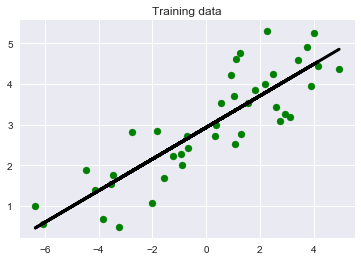

In [14]:
from sklearn import linear_model

#Create linear regresion object
lin_regressor = linear_model.LinearRegression()
lin_regressor.fit(Xtrain,ytrain)
ypred_train = lin_regressor.predict(Xtrain)

plt.figure()
plt.scatter(Xtrain,ytrain,color='g')
plt.plot(Xtrain,ypred_train,'k',lw=3.0)
plt.title('Training data')

Now see how linear_model does on test data

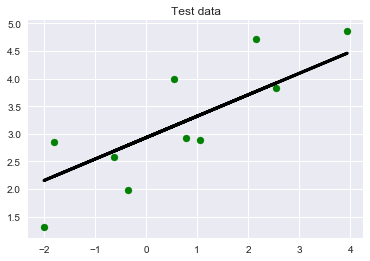

In [15]:
ypred_test = lin_regressor.predict(Xtest)
plt.scatter(Xtest,ytest,color='g')
plt.plot(Xtest,ypred_test,'k',lw=3.0)
plt.title('Test data')

## 1.4 Computing regression accuracy <a class="anchor" id="regacc"></a>
Metrics:
- **Mean absolute error**: average of absolute errors of all datapoints
- **Mean square error**: average of the squares of the errors of all datapoints, more popular
- **Median absolute error**: median of all errors in the dataset, robust to outliers
- **Explained variance score**: how well model account for the variation in dataset, 1.0 is perfect
- **R^2 score**: refers to coefficient of determination, how well unknow samples will be predicted by model, best is 1.0


In [16]:
import sklearn.metrics as sm

def evaluate_model(ytest,ypred_test):
    metrics = pd.DataFrame({'Metric':['Mean absolute error','Mean squared error','Median absolute error','Explained variance','R2score']})
    metricvals=[]
    # Mean absolute error
    metricvals.append(round( sm.mean_absolute_error(ytest,ypred_test),2))
    # Mean squared error
    metricvals.append(round( sm.mean_squared_error(ytest,ypred_test),2))
    # Median absolute error
    metricvals.append(round(sm.median_absolute_error(ytest,ypred_test),2))
    # Explained variance
    metricvals.append(round(sm.explained_variance_score(ytest,ypred_test),2))
    # R2score
    metricvals.append(round(sm.r2_score(ytest,ypred_test),2))
    metrics['Values'] = metricvals
    return metrics

In [17]:
metrics = evaluate_model(ytest,ypred_test)
metrics.head()

,Metric,Values
0,Mean absolute error,0.54
1,Mean squared error,0.39
2,Median absolute error,0.54
3,Explained variance,0.67
4,R2score,0.67


## 1.5 Acheiving model persistence  <a class="anchor" id="modpers"></a>
How to save model so we can access at later point

In [18]:
import _pickle as pickle
output_model_file = 'saved_model.pk1'
pickle.dump(lin_regressor,open(output_model_file,'wb'))

In [19]:
with open(output_model_file,'rb') as f:
    model_linregr = pickle.load(f)

ytest_predn = model_linregr.predict(Xtest)
print("\n New R2score = ", round( sm.r2_score(ytest,ytest_predn),2))


 New R2score =  0.67


## 1.6 Building a ride regressor  <a class="anchor" id="ridge"></a>
Problem with linear regression is sensitivity to outliers, since ordinary least squares which tries to minimize the square of the errors. Outliers cause problems because they contribute a lot to overall error. OLS considers every datapoint when building the model, to avoid this we use **regularization** where a penalty is imposed on the size of the coefficents.

In [20]:
data = pd.read_csv('data_multivar.txt',names=['x1','x2','x3','y'])
display( data.head() )
#Train Data
Xtrain= data.drop(['y'],axis=1)
ytrain= data[['y']]

,x1,x2,x3,y
0,0.39,2.78,7.11,-8.07
1,1.65,6.70,2.42,12.24
2,5.67,6.38,3.79,23.96
3,2.31,6.27,4.80,4.29
4,3.67,6.67,2.38,16.37


Alpha sets the penalty, closer to 0 is OLS solution

**Ridge regression**

In [21]:
alpha=0.1
ridge_regr = linear_model.Ridge(alpha=alpha,fit_intercept=True,max_iter=10000)
ridge_regr.fit(Xtrain,ytrain)
ypred_ridge=ridge_regr.predict(Xtrain)

metrics = evaluate_model(ytrain,ypred_ridge)
metrics.head()

,Metric,Values
0,Mean absolute error,3.51
1,Mean squared error,20.30
2,Median absolute error,3.03
3,Explained variance,0.86
4,R2score,0.86


** OLS **

In [22]:
ols = linear_model.LinearRegression()
ols.fit(Xtrain,ytrain)
ypred_ols = ols.predict(Xtrain)

metrics = evaluate_model(ytrain,ypred_ols)
metrics.head()

,Metric,Values
0,Mean absolute error,3.51
1,Mean squared error,20.30
2,Median absolute error,3.03
3,Explained variance,0.86
4,R2score,0.86


## 1.7 Building a polynomial regressor  <a class="anchor" id="poly"></a>
One of the constrains of linear regression is that it tries to fit a linear function to the input data, polynomial regression overcomes this issue.

In [23]:
from sklearn.preprocessing import PolynomialFeatures
polynomial = PolynomialFeatures(degree=10)

Xtrain_trans = polynomial.fit_transform(Xtrain)

Xtrain_trans represents the same input in the polynomial form

In [24]:
datpoint = Xtrain.ix[0,:];print(datpoint)

x1    0.39
x2    2.78
x3    7.11
Name: 0, dtype: float64


In [25]:
poly_datpoint = polynomial.fit_transform(datpoint)
poly_linear_model = linear_model.LinearRegression()
poly_linear_model.fit(Xtrain_trans,ytrain)
print('Linear Regression:',ols.predict(datpoint)[0])
print('Polynomial Regression:',poly_linear_model.predict(poly_datpoint)[0])

Linear Regression: [-10.5249081]
Polynomial Regression: [-8.2115757]


/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


In [26]:
ypred_poly = poly_linear_model.predict(Xtrain_trans)
metrics = evaluate_model(ytrain,ypred_poly)
metrics.head()

,Metric,Values
0,Mean absolute error,2.13
1,Mean squared error,9.12
2,Median absolute error,1.44
3,Explained variance,0.94
4,R2score,0.94


## 1.8 Estimating Housing Pricing  <a class="anchor" id="house"></a>
This is one of the most popular datasets for regression. We will use a **decision tree regressor** with **AdaBoost** to solve this problem.

Decision tree is a tree where each node makes a simple decision that contributes to the final output. The leaf nodes represent the output values, and the branches represent the intermediate decisions that were made, based on input features. **AdaBoost** stands for adaptive boosting, and this is a technique that is used to boost the accuracy of the results from another system. This combines the outputs from different versions of the algorithms, called **weak learners** using a weighted summation to get the final output. Information that is callected at each stage of the AdaBoost algorithm is fed back to the system so that the learners at the latter stages focus on training samples that are difficult to classify. This is how it increases the accuracy.

One of the most comprehensible non-parametric methods is k-nearest-neighbors: find the points which are most similar to you, and do what, on average, they do. There are two big drawbacks to it: first, you’re defining “similar” entirely in terms of the inputs, not the response; second, k is constant everywhere, when some points just might have more very-similar neighbors than others. Trees get around both problems: leaves correspond to regions of the input space (a neighborhood), but one where the responses are similar, as well as the inputs being nearby; and their size can vary arbitrarily. Prediction trees are adaptive nearest-neighbor methods.

Using AdaBoost we fit a regressor on the dataset, compute the error then fit the regressor on the same dataset again based on error estimate. Can think of this as fine tuning the regressor.

In [27]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn import datasets
import sklearn.metrics as sm

This is the most common dataset, of Boston housing, there are 13 input parameters that affect the price of the house.

In [28]:
housing_data = datasets.load_boston()
print(housing_data.keys())
print(housing_data.DESCR)
features = housing_data.feature_names
print(features)

dict_keys(['data', 'target', 'feature_names', 'DESCR'])
Boston House Prices dataset

Notes
------
Data Set Characteristics:  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive
    
    :Median Value (attribute 14) is usually the target

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,0

### Convert into pandas data frame for ease

In [29]:
houseDF = pd.DataFrame(housing_data.data,columns=features)
houseDF['TARGET'] = housing_data.target
houseDF.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


Below we will shuffle the data to make sure it is independent of ordering

In [30]:
houseDF = houseDF.sample(frac=1,random_state=7).reset_index(drop=True)
houseDF.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,3.84970,0.0,18.10,1.0,0.770,6.395,91.0,2.5052,24.0,666.0,20.2,391.34,13.27,21.7
1,0.03041,0.0,5.19,0.0,0.515,5.895,59.6,5.6150,5.0,224.0,20.2,394.81,10.56,18.5
2,0.24103,0.0,7.38,0.0,0.493,6.083,43.7,5.4159,5.0,287.0,19.6,396.90,12.79,22.2
3,0.62976,0.0,8.14,0.0,0.538,5.949,61.8,4.7075,4.0,307.0,21.0,396.90,8.26,20.4
4,73.53410,0.0,18.10,0.0,0.679,5.957,100.0,1.8026,24.0,666.0,20.2,16.45,20.62,8.8


Now let's split the data into training and test, 20% to test

In [31]:
from sklearn.model_selection import train_test_split
num_test=0.2
houseX = houseDF.drop(['TARGET'],axis=1);houseY = houseDF[['TARGET']]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(houseX, houseY, test_size=num_test, random_state=23)
Xtrain.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.761492,10.544554,11.383936,0.071782,0.557234,6.255106,68.977228,3.787820,9.772277,412.861386,18.490347,355.715074,12.936287
std,8.319861,22.111728,6.779134,0.258447,0.116162,0.683277,28.604629,2.132619,8.816161,168.600076,2.160434,92.402796,7.222240
min,0.006320,0.000000,0.740000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.086270,0.000000,5.320000,0.000000,0.452000,5.887750,43.625000,2.084875,4.000000,284.000000,17.225000,374.650000,7.320000
50%,0.273975,0.000000,9.900000,0.000000,0.538000,6.198500,78.800000,3.167500,5.000000,337.000000,19.100000,391.045000,11.690000
75%,4.128648,12.500000,18.100000,0.000000,0.631000,6.565500,94.425000,5.212575,24.000000,666.000000,20.200000,396.307500,17.127500
max,73.534100,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


Now we have 404 samples in the training data and 102 in the test data

### Decision Regression on Raw Data
Also fit a model with AdaBoost. An advantage of decision trees is that it requires very little data preperation.

In [32]:
#Decision tree
dt_regressor = DecisionTreeRegressor(max_depth=4)
dt_regressor.fit(Xtrain,Ytrain)
ypred_dt = dt_regressor.predict(Xtest)
# AdaBoost
ab_regressor = AdaBoostRegressor(DecisionTreeRegressor(max_depth=4),n_estimators=400,random_state=7)
ab_regressor.fit(Xtrain,Ytrain)
ypred_ab = ab_regressor.predict(Xtest)

/anaconda/lib/python3.6/site-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Evaluate model results

In [33]:
dt_metrics = evaluate_model(Ytest,ypred_dt)
ab_metrics = evaluate_model(Ytest,ypred_ab)
print('Decision Tree:');display( dt_metrics.head() )
print('AdaBoost Decision Tree:');display( ab_metrics.head())

Decision Tree:


,Metric,Values
0,Mean absolute error,2.66
1,Mean squared error,12.00
2,Median absolute error,2.00
3,Explained variance,0.89
4,R2score,0.89


AdaBoost Decision Tree:


,Metric,Values
0,Mean absolute error,2.35
1,Mean squared error,9.66
2,Median absolute error,1.68
3,Explained variance,0.91
4,R2score,0.91


## 1.9 Computing relative importance of features  <a class="anchor" id="featimport"></a>
How do we know in the previous housing data set which features are the most important? They shouldn't all contribute equally. 

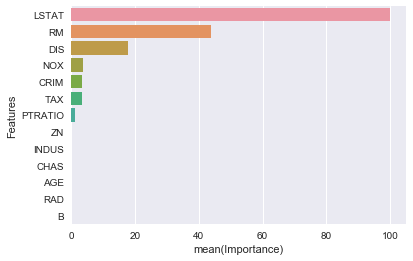

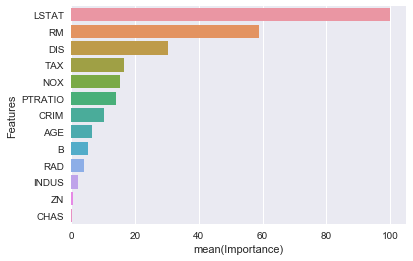

In [34]:
def plot_feature_importance(feature_importances,feature_names):
    # Normalize the importance values
    feature_importances = 100.*(feature_importances/max(feature_importances))
    fiDF= pd.DataFrame({'Features':feature_names,'Importance':feature_importances})
    # Sort
    fiDF= fiDF.sort_values(by='Importance',ascending=False)
    # Plot
    plt.figure()
    sns.barplot(x='Importance', y='Features',data=fiDF,orient='h')
plot_feature_importance(dt_regressor.feature_importances_,features)
plot_feature_importance(ab_regressor.feature_importances_,features)

## 1.10 Estimating Bicycle Demand Distribution  <a class="anchor" id="bicycle"></a>
We will use the random forest regressor to estimate the output values. A random forest is a collection of decision trees; uses a set of decision trees that are built using various subsets of the dataset, and then it uses averaging to improve the overall performance.

There are 16 columns in *bike_day.csv* first 2 correspond to serial # and actual date. The last 3 columns correspond to different types of outputs. The last column is the sum of the values in 14 and 15th.


In [35]:
bikeDF = pd.read_csv('bike_day.csv')
bikeDF.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


Drop the instant and dteday columns and also casual and registered

In [36]:
bikeDF = bikeDF.drop(['instant','dteday','registered','casual'],axis=1)

### Normalize the weather features

In [37]:
scaler = preprocessing.StandardScaler()
weatherfeatures= ['temp','atemp','hum','windspeed']
bikeDF[weatherfeatures] = scaler.fit_transform(bikeDF[weatherfeatures])
bikeDF.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,-0.826662,-0.679946,1.250171,-0.387892,985
1,1,0,1,0,0,0,2,-0.721095,-0.740652,0.479113,0.749602,801
2,1,0,1,0,1,1,1,-1.634657,-1.749767,-1.339274,0.746632,1349
3,1,0,1,0,2,1,1,-1.614780,-1.610270,-0.263182,-0.389829,1562
4,1,0,1,0,3,1,1,-1.467414,-1.504971,-1.341494,-0.046307,1600


Separate into training and test dataset, let's use 10% for test. Looks like data has already been normalized.

In [38]:
from sklearn.model_selection import train_test_split
num_test=0.1
bikeX = bikeDF.drop(['cnt'],axis=1);bikeY = bikeDF[['cnt']]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(bikeX, bikeY, test_size=num_test, random_state=23)
Xtrain.describe()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000
mean,2.488584,0.502283,6.496195,0.030441,2.964992,0.694064,1.392694,0.022437,0.023256,0.005081,-0.015798
std,1.103048,0.500376,3.420312,0.171929,1.984772,0.461154,0.539146,0.989234,0.987390,0.992874,0.987380
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,-2.175711,-2.199446,-4.411486,-2.170506
25%,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,-0.831221,-0.811742,-0.728770,-0.732976
50%,3.000000,1.000000,7.000000,0.000000,3.000000,1.000000,1.000000,0.066230,0.114830,0.008943,-0.122813
75%,3.000000,1.000000,9.000000,0.000000,5.000000,1.000000,2.000000,0.877122,0.835949,0.714451,0.551590
max,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,2.002355,2.250800,2.421148,4.092936


### Random Forest Regression data
n_estimators below refers to the number of decision trees that we want to use in our random forest

max_depth maximum depth of each tree

min_samples_split refers to the number of samples that are need to split a node in the tree

In [39]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=2000,max_depth=32,min_samples_split=2,oob_score=True)
rf_regressor.fit(Xtrain,Ytrain)
y_pred_rf = rf_regressor.predict(Xtest)
print('done!')

/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


done!


,Metric,Values
0,Mean absolute error,459.07
1,Mean squared error,406915.95
2,Median absolute error,330.74
3,Explained variance,0.90
4,R2score,0.90


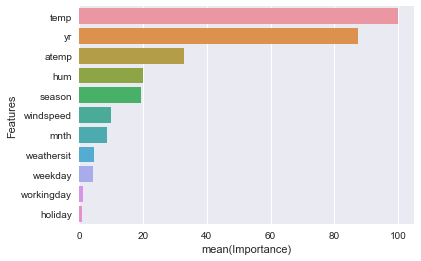

In [40]:
rf_metrics=evaluate_model(Ytest,y_pred_rf)
display(rf_metrics.head())
plot_feature_importance(rf_regressor.feature_importances_,Xtrain.columns.values)

### Redo the above but with hourly data included
The next dataset includes hour of day as well, repeat all the above


In [41]:
bikeDF = pd.read_csv('bike_hour.csv')
bikeDF = bikeDF.drop(['instant','dteday','registered','casual'],axis=1)
bikeDF[weatherfeatures] = scaler.fit_transform(bikeDF[weatherfeatures])
bikeX = bikeDF.drop(['cnt'],axis=1);bikeY = bikeDF[['cnt']]
Xtrain, Xtest, Ytrain, Ytest = train_test_split(bikeX, bikeY, test_size=num_test, random_state=23)
Xtrain.describe()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
count,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000,15641.000000
mean,2.502014,0.501950,6.550668,11.549581,0.029282,3.006649,0.682565,1.427338,-0.001214,-0.001353,-0.000072,0.001471
std,1.106427,0.500012,3.442217,6.916749,0.168601,2.004460,0.465493,0.641074,0.999914,1.001245,0.999194,1.002968
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-2.477205,-2.768625,-3.251166,-1.553889
25%,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,-0.815304,-0.829089,-0.763143,-0.699689
50%,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.015647,0.052518,0.014364,0.031899
75%,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.846597,0.846255,0.791871,0.519896
max,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,2.612367,3.050563,1.932215,5.399871


/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  from ipykernel import kernelapp as app


done!


,Metric,Values
0,Mean absolute error,25.13
1,Mean squared error,1955.65
2,Median absolute error,13.30
3,Explained variance,0.94
4,R2score,0.94


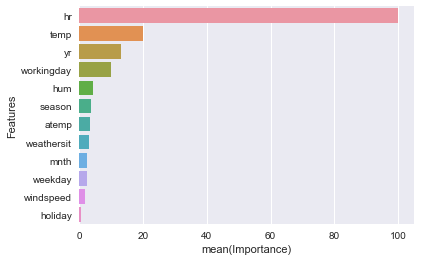

In [42]:
rf_regressor = RandomForestRegressor(n_estimators=2000,max_depth=32,min_samples_split=2,oob_score=True)
rf_regressor.fit(Xtrain,Ytrain)
y_pred_rf = rf_regressor.predict(Xtest)
print('done!')
rf_metrics=evaluate_model(Ytest,y_pred_rf)
display(rf_metrics.head())
plot_feature_importance(rf_regressor.feature_importances_,Xtrain.columns.values)

From the above we conclude that including hour of day for bike rental is the most important, then temperature. Explained variance is quite good at 0.94 with hour of day.